In [1]:
import cfgrib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected
import torch_geometric.data as data
from torch.utils.data import DataLoader

sys.path.append('..')
from baselines.data_processor import DataProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
INPUT_SIZE = 4
BATCH_SIZE = 4
FH = 1

In [4]:
t2m_numpy = surface.t2m.to_numpy()
sp_numpy = surface.sp.to_numpy()
dataset = np.stack((t2m_numpy, sp_numpy), axis=-1)
_, num_latitudes, num_longitudes, num_features = dataset.shape
print(dataset.shape)

(1432, 25, 45, 2)


In [5]:
processor = DataProcessor(dataset)
X, y = processor.preprocess(INPUT_SIZE)
X.shape

(1428, 25, 45, 4, 2)

In [6]:
# X = X.transpose((0,1,2,4,3))
# y = y.transpose((0,1,2,4,3))
# X = X.reshape(-1, num_latitudes*num_longitudes, num_features, INPUT_SIZE)
# y = y.reshape(-1, num_latitudes*num_longitudes, num_features, FH)
X = X.reshape(-1, num_latitudes*num_longitudes, INPUT_SIZE, num_features)
y = y.reshape(-1, num_latitudes*num_longitudes, FH, num_features)

X.shape, y.shape

((1428, 1125, 4, 2), (1428, 1125, 1, 2))

In [8]:
def node_index(i, j, num_cols):
    return i * num_cols + j

edge_index = []
for i in range(num_latitudes):
    for j in range(num_longitudes):
        if i > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i - 1, j, num_longitudes)])
        if j > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i, j - 1, num_longitudes)])
            
edge_index = torch.tensor(edge_index, dtype=torch.long).t()
print(edge_index.size())
edge_index = to_undirected(edge_index)
print(edge_index.size())

torch.Size([2, 2180])
torch.Size([2, 4360])


In [9]:
dataset = []
for i in range(X.shape[0]):
    Xi=torch.from_numpy(X[i].astype('float32')).to(device)
    yi=torch.from_numpy(y[i].astype('float32')).to(device)
    g = data.Data(x=Xi, edge_index=edge_index, y=yi)
    g = g.to(device)
    dataset.append(g)

dataset[100]

Data(x=[1125, 4, 2], edge_index=[2, 4360], y=[1125, 1, 2])

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_dim, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=hidden_dim,
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(hidden_dim, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

hidden_dim = 2048
TemporalGNN(node_features=INPUT_SIZE, hidden_dim=hidden_dim, periods=FH*num_features)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(4, 2048)
      (linear_z): Linear(in_features=4096, out_features=2048, bias=True)
      (conv_r): GCNConv(4, 2048)
      (linear_r): Linear(in_features=4096, out_features=2048, bias=True)
      (conv_h): GCNConv(4, 2048)
      (linear_h): Linear(in_features=4096, out_features=2048, bias=True)
    )
  )
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)

In [11]:
model = TemporalGNN(node_features=INPUT_SIZE, hidden_dim=hidden_dim, periods=FH*num_features)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
criterion = criterion.to(device)
edge_index = edge_index.to(device)

train_ratio = 0.7
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
val_size = num_samples - train_size
train_data, val_data = dataset[:train_size], dataset[train_size:]
print("Number of train buckets: ", train_size)
print("Number of test buckets: ", val_size)

Number of train buckets:  999
Number of test buckets:  429


In [13]:
# y_hat.shape, batch.y.shape, batch.x.shape

In [ ]:
num_epochs = 200
# val_loss_list = []
# train_loss_list = []
subset = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    step = 0
    for batch in train_data:
        optimizer.zero_grad()
        y_hat = model(batch.x, batch.edge_index)
        y_hat = y_hat.view(-1, 1, 2)
        loss = criterion(y_hat, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        step+=1
        if step > subset:
            break
            
    avg_loss = total_loss / train_size
    print(f"Epoch {epoch + 1}/{num_epochs}\nTrain Loss: {avg_loss:.4f}")
    train_loss_list.append(avg_loss)
    
    model.eval()
    step = 0
    with torch.no_grad():
        val_loss = 0
        for batch in val_data:
            y_hat = model(batch.x, batch.edge_index)
            y_hat = y_hat.view(-1, 1, 2)
            loss = criterion(y_hat, batch.y)
            val_loss += loss.item()
            step+=1
            if step > subset:
                break
       
    avg_val_loss = val_loss / val_size
    print(f"Val Loss: {avg_val_loss:.4f}\n---------")
    val_loss_list.append(avg_val_loss)


In [ ]:
# 58mln -> 19k in ~ 1500 epochs ~ 40min

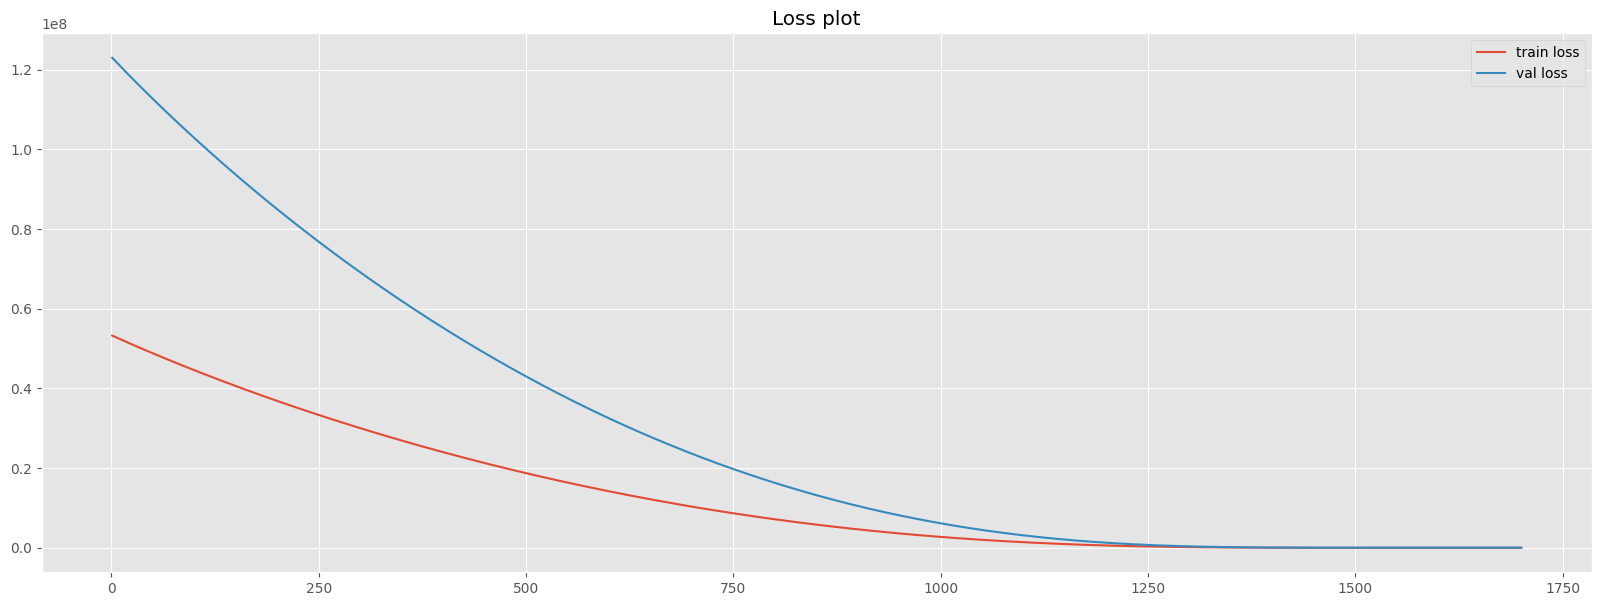

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = np.arange(1, len(train_loss_list)+1)
plt.figure(figsize=(20,7))
plt.plot(x, train_loss_list, label = 'train loss')
plt.plot(x, val_loss_list, label = 'val loss')
plt.title('Loss plot')
plt.legend()
plt.show()

In [ ]:
# for batch in val_loader:
#     break
# batch = batch.to(device)
# predicted = model(batch, edge_index)
# predicted.shape
# predicted_grid = predicted.reshape(num_latitudes, num_longitudes, -1)
# temp_grid = predicted_grid[:,:,0] -  273.15
# plt.imshow(temp_grid.cpu().detach().numpy())
# plt.show()

In [ ]:
sample = val_data[0]
X = sample.x
y = sample.y
y_hat = model(X, edge_index)

loss = criterion(y, y_hat)
loss = loss.cpu()
loss